# Traffic forecasting

### Robin San Roman

In [1]:
import geopandas as gpd
from geopandas.tools import sjoin
from IPython.core.display import Image 
import pandas as pd
import shapely as shp
import pylab as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
import numpy as np
import statsmodels.api as sm
import time
#import tqdm.notebook as tqdm

def plot(X,Y,label = None):
    plt.figure(figsize=(20,10))
    for i in range(len(X)) :
        plt.plot(X[i],Y[i],label = label[i])
    plt.legend()

area_file = "com_areas.geojson"  #file for the area in which we want to forecast the trucks 

area_df = gpd.read_file(area_file)
area_gs = gpd.GeoSeries(area_df['geometry'])

dataf = pd.read_csv('1hour_data.csv') # CSV file for trucks position 

## Dell everything which is not relevant in the dataframes

del dataf['Districts']
del dataf['Region']
del dataf['avg_vel']
dataf['Coordinate'] = list(zip(dataf.lat,dataf.lon))
dataf['geometry'] = dataf['Coordinate'].apply(shp.geometry.Point)
del dataf['lat']
del dataf['lon']
del dataf['Coordinate']
del area_df['created_by']
del area_df['addr:housename']
del area_df['addr:housenumber']
del area_df['addr:postcode']
del area_df['addr:street']
del area_df['name:fr']
del area_df['name']
del area_df['name:nl']
del area_df['traffic_calming']
del area_df['@id']
del area_df['id']


I modified the dataframe in order to change the columns lat and lon for a column Coordinate which is the Serie of the Points in the geometric structure (shp.geometry).

In [2]:
join_left_df = sjoin(gpd.GeoDataFrame(dataf), gpd.GeoDataFrame(area_df), how="left")
join_left_df['Inthearea'] = (join_left_df['landuse']).eq('commercial')
del join_left_df['landuse']

In [3]:
df = join_left_df.pivot(index = 'ID', columns = 'datetime', values = 'Inthearea')

Here I created a new data frame with the different time as columns and the diffenrent ID as rows. My assumption is that each element in $ID\times Datetime$ appears at most once.

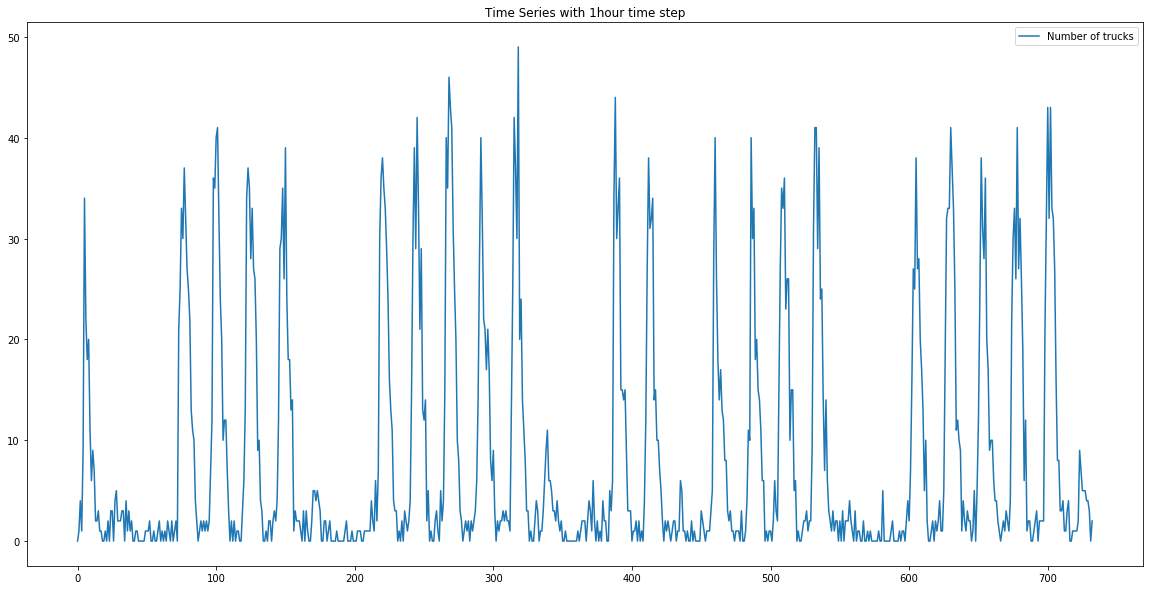

In [4]:
yy = df.apply(pd.value_counts).fillna(0)
y = list(yy.iloc[1]) # y is now the complete time series that
x_y = [i for i in range(len(y))]
plt.figure(figsize = (20,10))
plt.plot(x_y,y,label = 'Number of trucks')
plt.title("Time Series with 1hour time step")
plt.legend()


##  The parameters :

In [6]:
fordata = y
num_train = 3*24*7 #size of the trainnig set
train = fordata[:num_train]
mu = np.sum(train)/num_train
test = fordata[num_train:]
prediction_horizon = 12
num_test = 4*24*7 - prediction_horizon #end of the test set (must be between the length of the train set and of the whole data set)

Bellow the the function that I use to compute the error normalized by the mean $ \varepsilon = \| \widehat{y} - y\|^2 / (\mu*n)$ where $ y,\widehat{y} \in \mathbb{R}^n $

In [7]:
def compute_err(yhat, test,mu):
    N = len(test)
    return(np.linalg.norm(np.array(test)-np.array(yhat))/ (N*mu))

## Naives Methodes 
Use The previous hour to predict the future. 

Use the same time intervall the last day/last week 

Use the mean of the training weeks


In [8]:
##### Last Time step. ####
err = []

for t in range(num_train,num_test) : 
    yhat = np.array([t-1]*prediction_horizon)
    err.append(compute_err(y[t:t+prediction_horizon],yhat,mu))

mean_err = np.sum(np.array(err))/len(err)

print(mean_err)

20.606776641264993


In [11]:
##### Last Day. #####
err = []

for t in range(num_train,num_test) : 
    yhat = y[t-24*7:t-24*7 +prediction_horizon]
    err.append(compute_err(y[t:t+prediction_horizon],yhat,mu))

mean_err = np.sum(np.array(err))/len(err)

print(mean_err)

0.4427210063115818


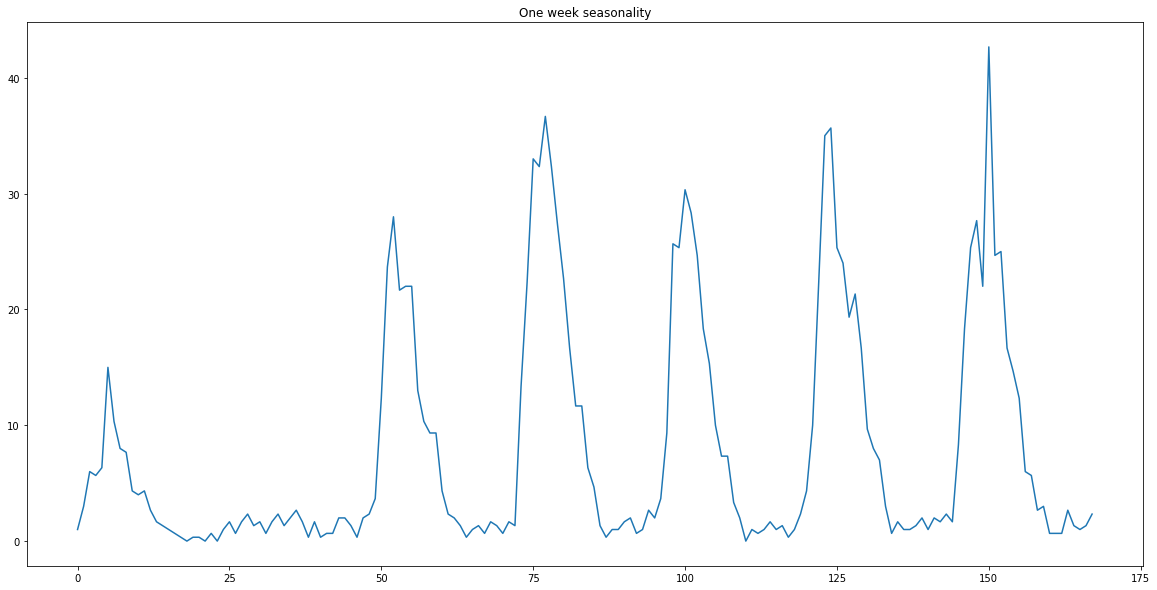

504


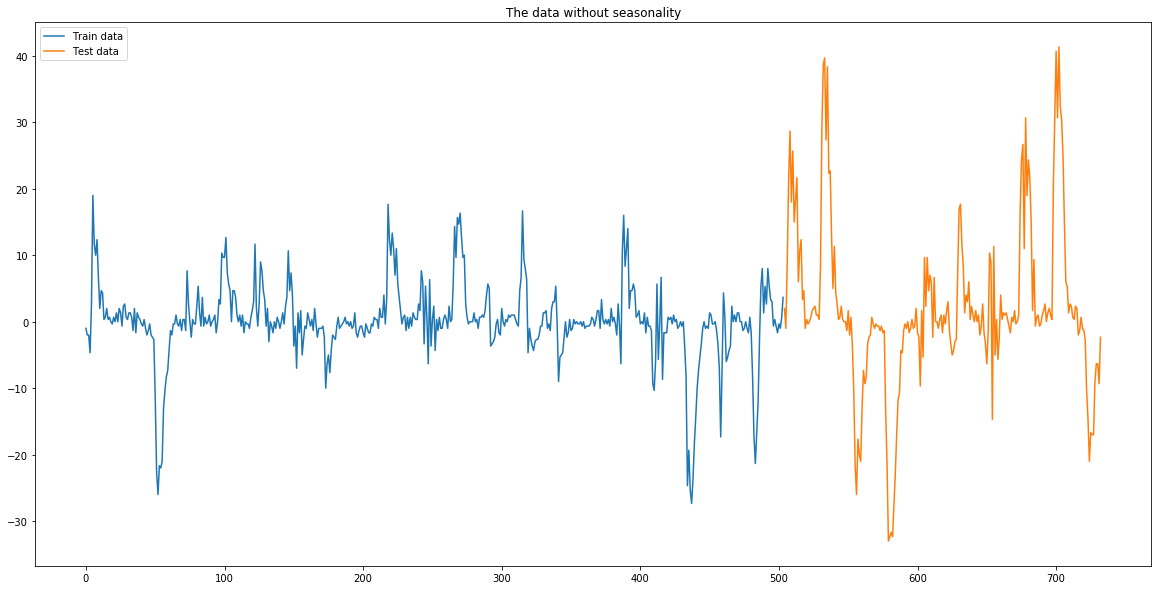

In [13]:
##### Computing the seasonality #####

seasonality = np.zeros(24*7)
ss = np.zeros(24*7)
for i in range(3*7*24) : 
    seasonality[(i%(7*24))] += y[i]/3
    ss[(i%(7*24))] += 1 

plt.figure(figsize = (20,10))
plt.plot([i for i in range(24*7)],seasonality)
plt.title('One week seasonality')
plt.show()
train_noseason = np.copy(train)
y_noseason = np.copy(y)

for i in range(num_train) : 
    train_noseason[i] -= seasonality[(i%(24*7))]
for i in range(len(y)) :
    y_noseason[i] -= seasonality[(i%(24*7))]

plt.figure(figsize = (20,10))
plt.plot([i for i in range(len(y))][:num_train],y_noseason[:num_train],label ='Train data')
plt.plot([i for i in range(len(y))][num_train:],y_noseason[num_train:],label ='Test data')
plt.title('The data without seasonality')
plt.legend()
print(num_train)

In [14]:
##### Using the seasonality as a predictor #####

err = []

for t in range(num_train,num_test) : 
    s = t%(7*24)
    yhat = seasonality[s :s+prediction_horizon]
    err.append(compute_err(y[t:t+prediction_horizon],yhat,mu))

mean_err = np.sum(np.array(err))/len(err)

print(mean_err)

0.33951718781773765


## Statistical models

We will test diffenrent statistical models with the same procedure as before. Each model will be tested with and without the seasonality. The models that we will test are :

-AR without/with seasonality

-ARIMA without/with seasonality

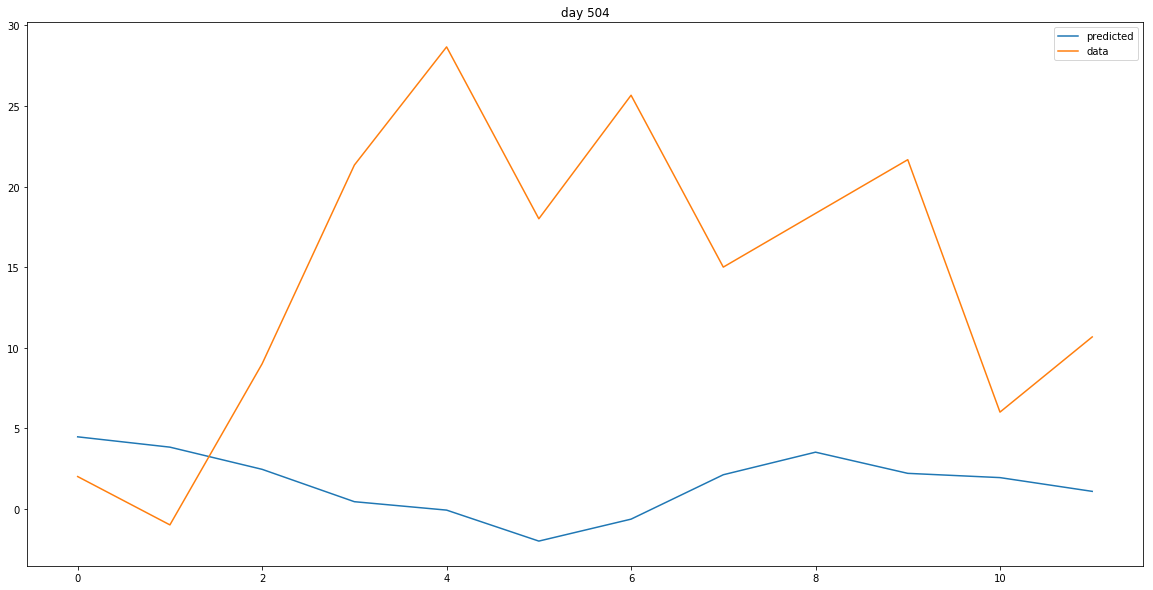

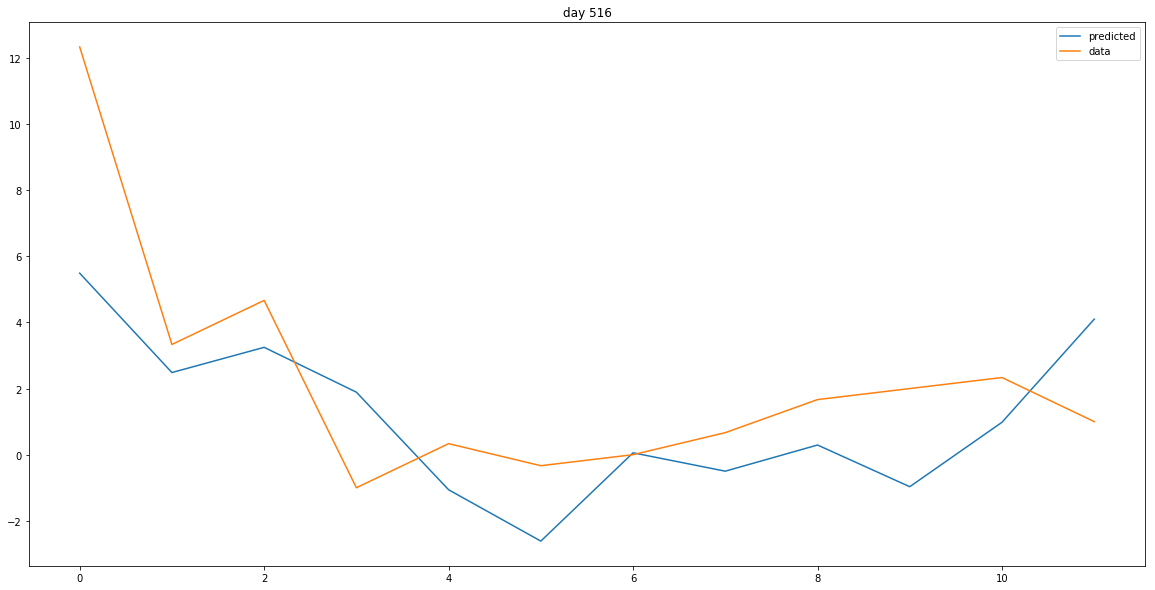

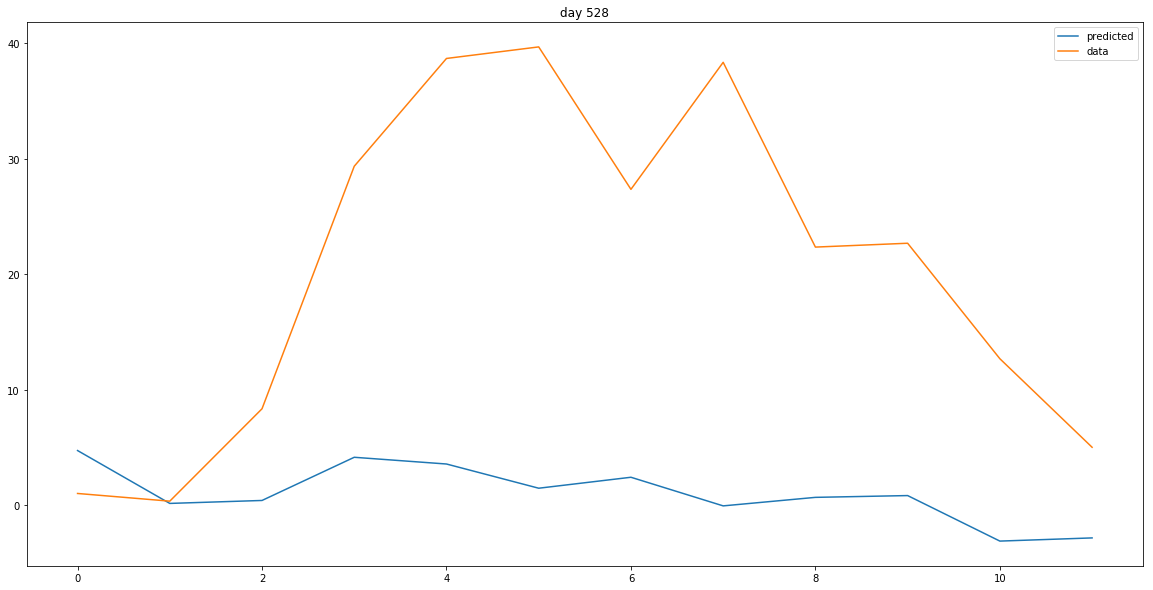

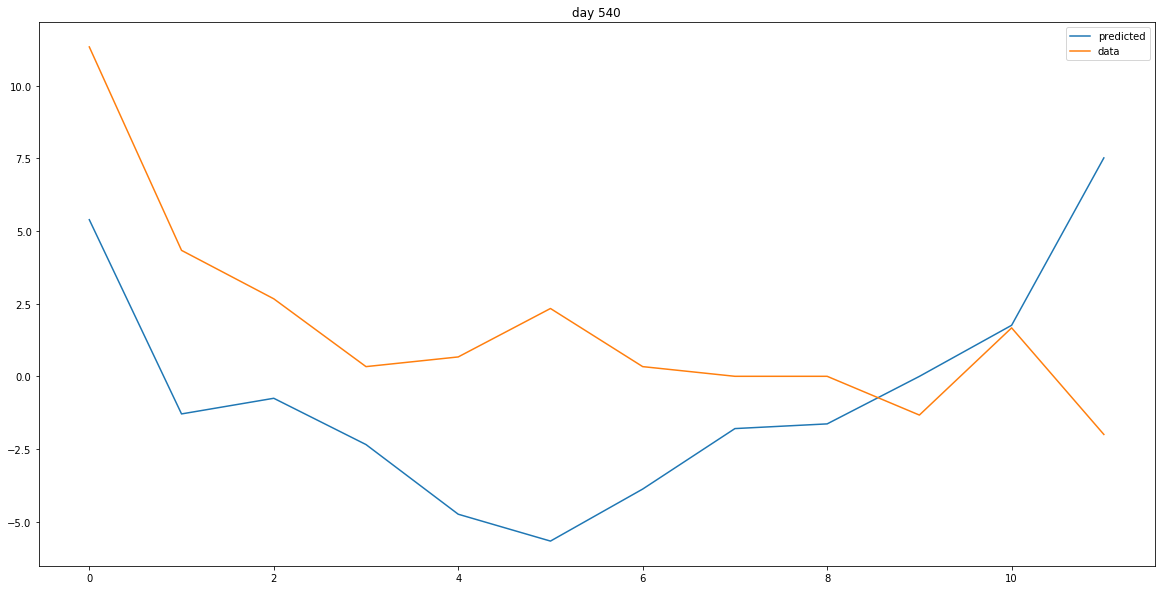

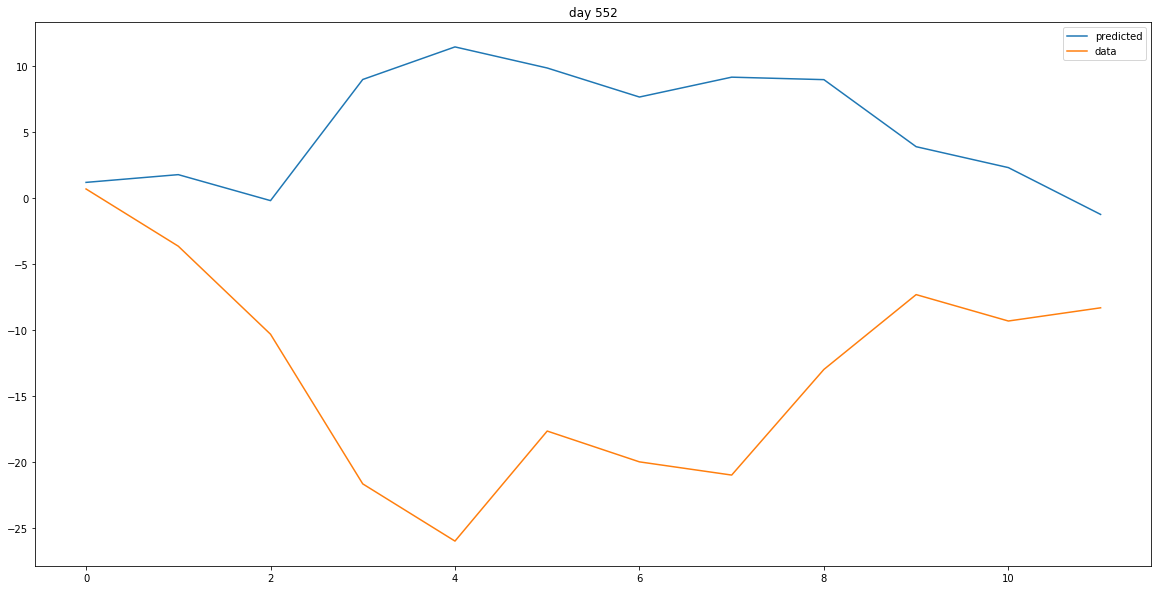

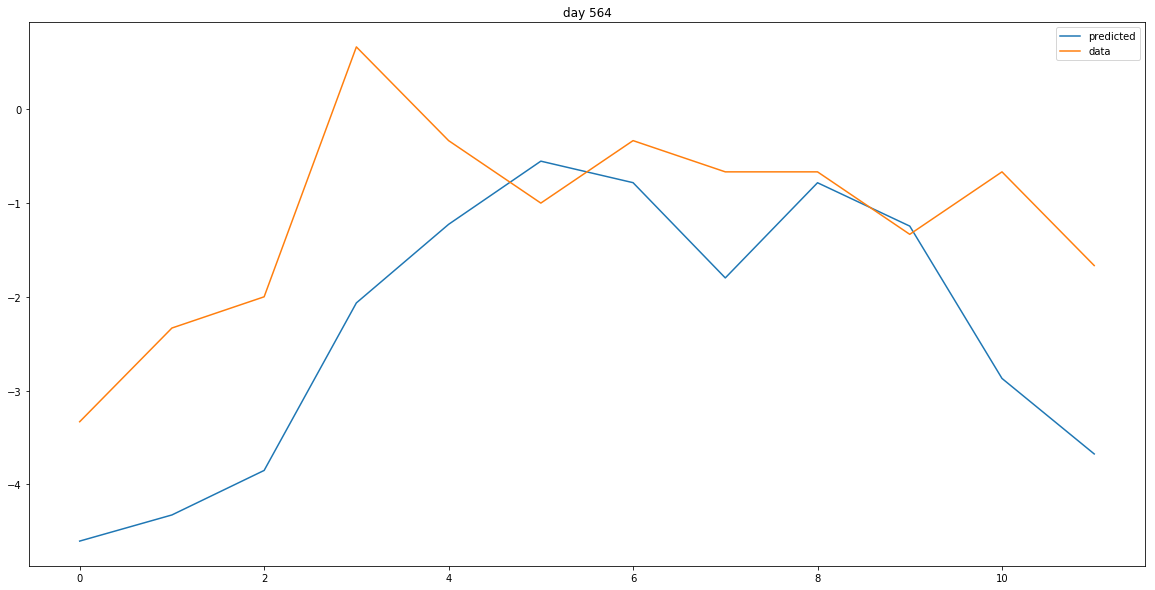

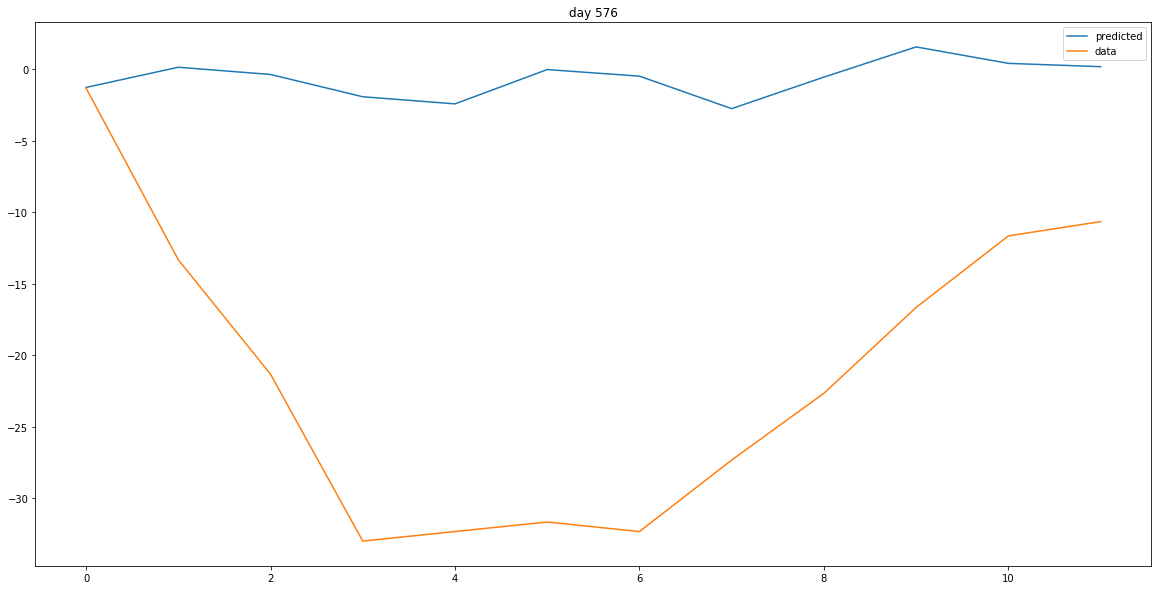

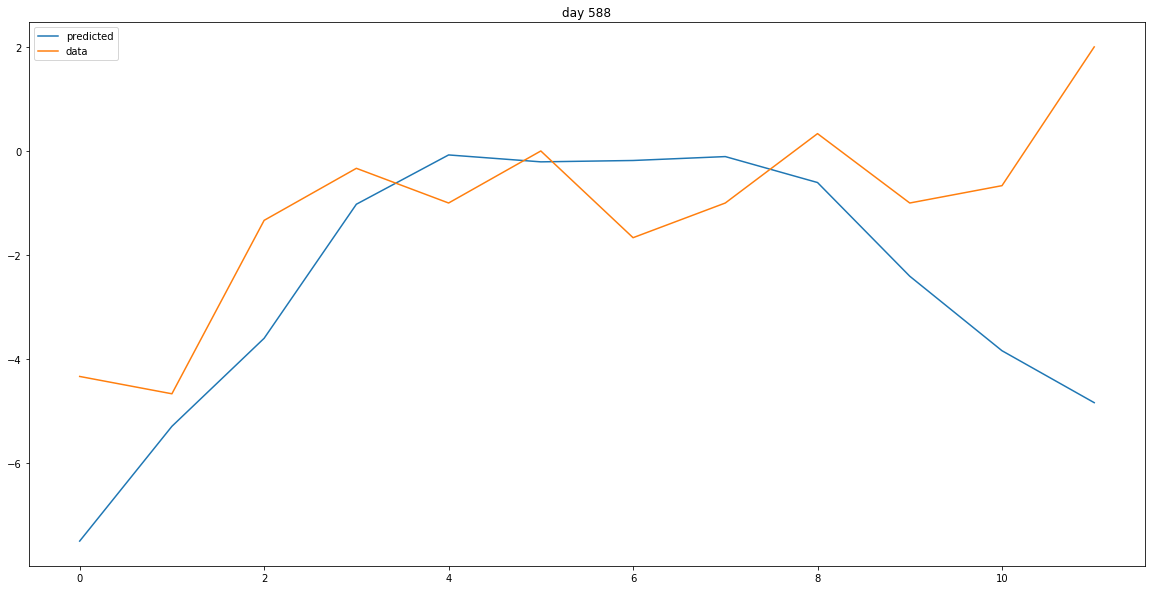

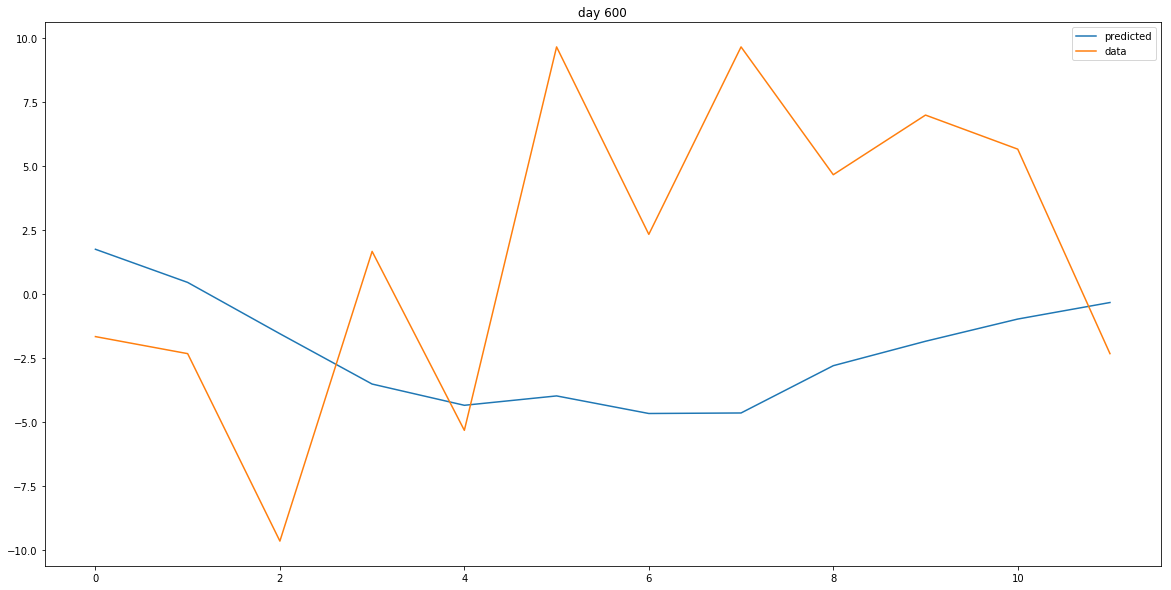

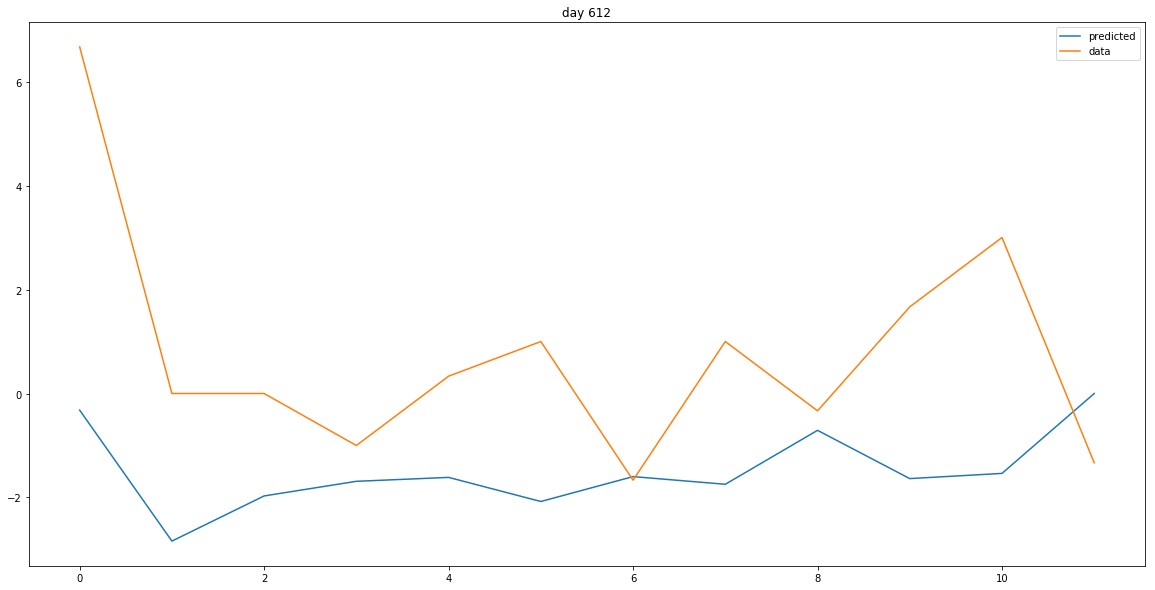

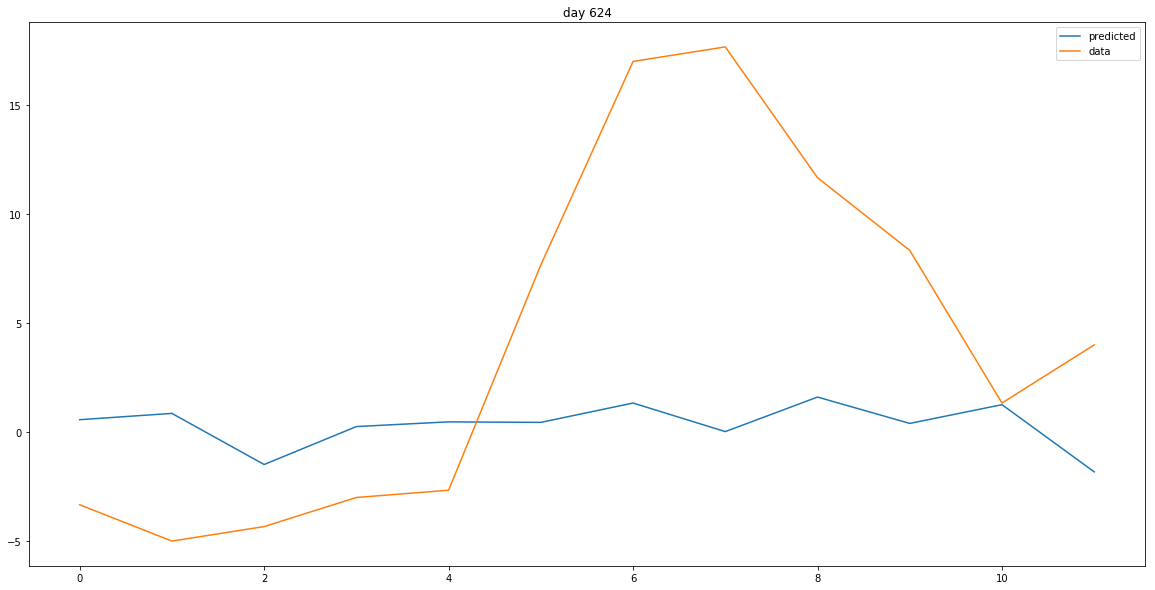

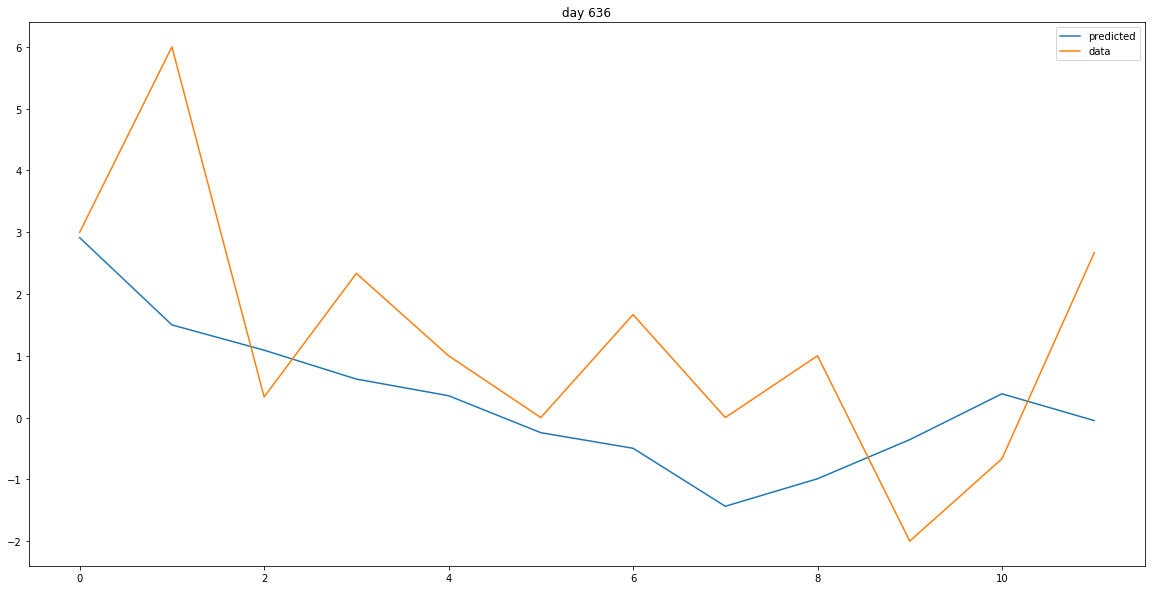

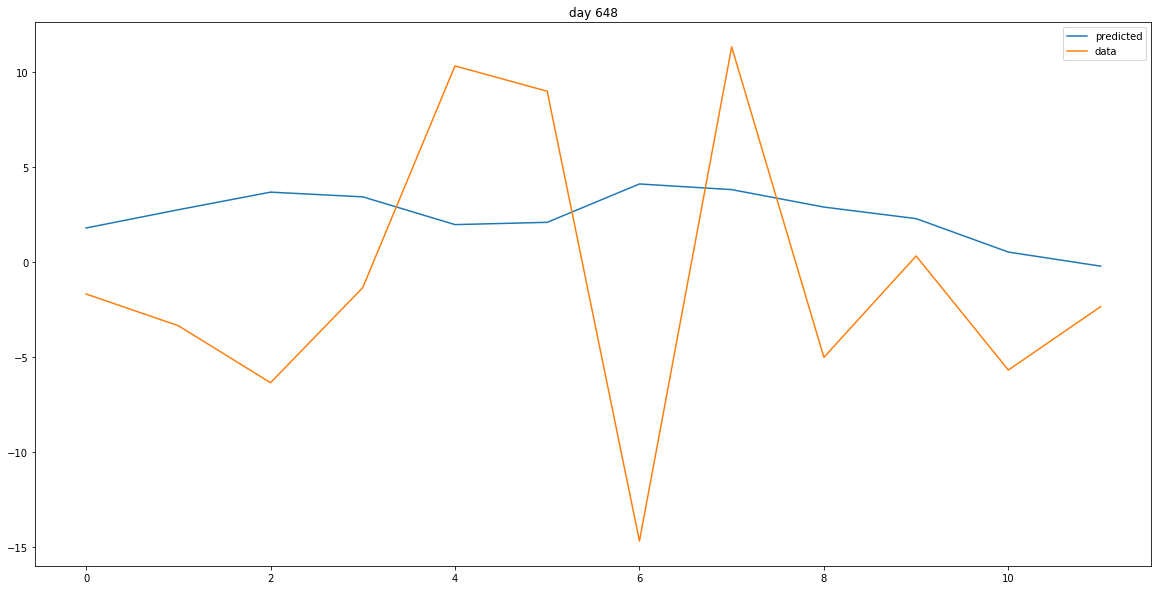

0.3117242269513895


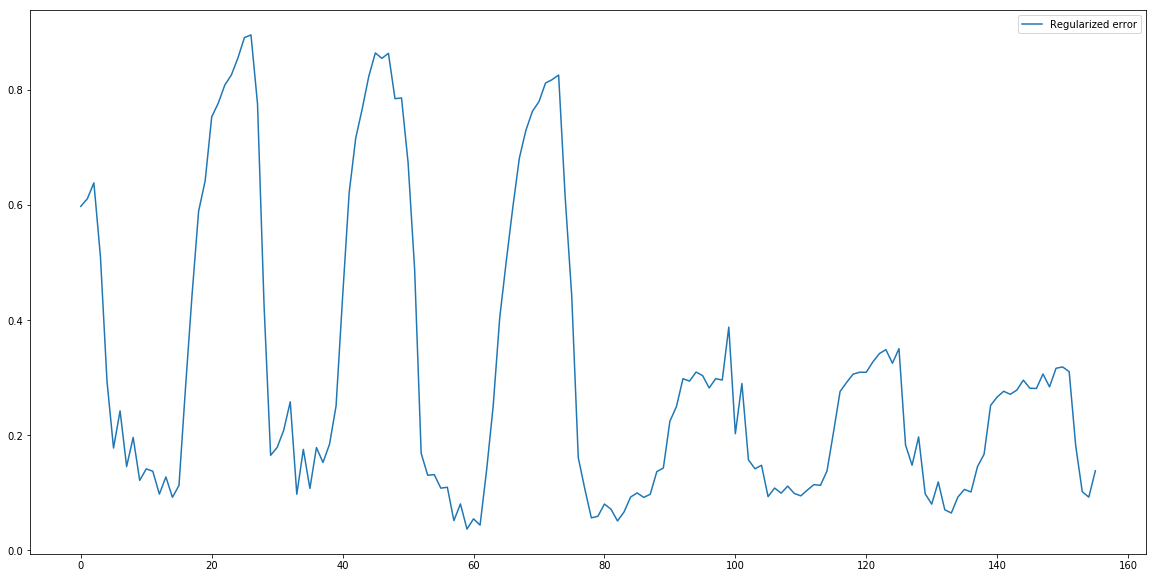

In [15]:
err = []

for i in range(num_train,num_test) :
    train = y_noseason[:i]
    test = y_noseason[i:]
    Ntest = len(test)
    Ntrain = len(train)
    model = AR(train)
    model_fit = model.fit(Ntrain -24)
    yhat = np.array(model_fit.predict(Ntrain,len(y)-1)[:prediction_horizon])
    err.append(compute_err(yhat,np.array(test[:prediction_horizon]),mu))
    if i%12 == 0 :
        plt.figure(figsize = (20,10))
        plt.plot(range(len(yhat[:prediction_horizon])),yhat[:prediction_horizon],label = 'predicted')
        plt.plot(range(len(yhat[:prediction_horizon])),test[:prediction_horizon], label = 'data')
        plt.title('day ' + str(i))
        plt.legend()
        plt.show()
    
print(np.sum(err)/len(err))
plt.figure(figsize = (20,10))
plt.plot(range(len(err)),err,label = 'Regularized error')
plt.legend()

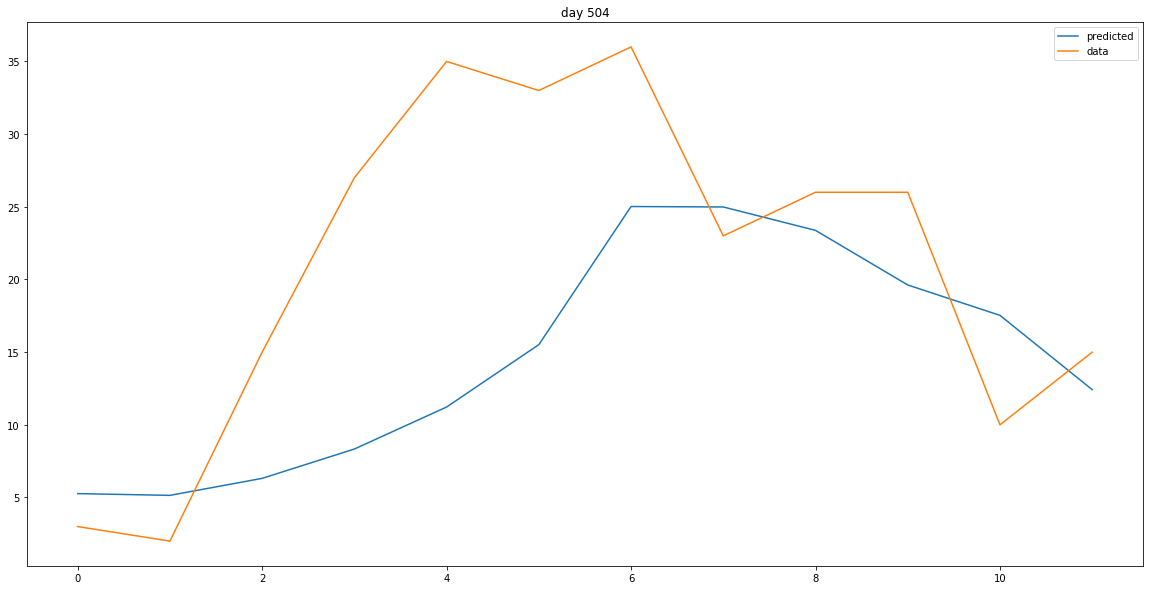

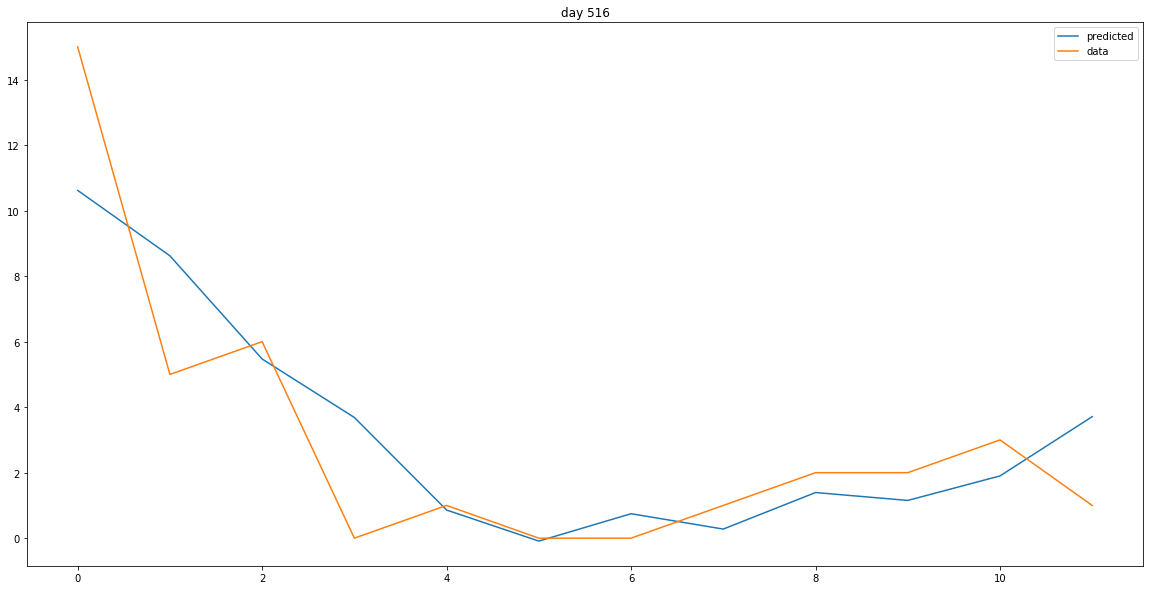

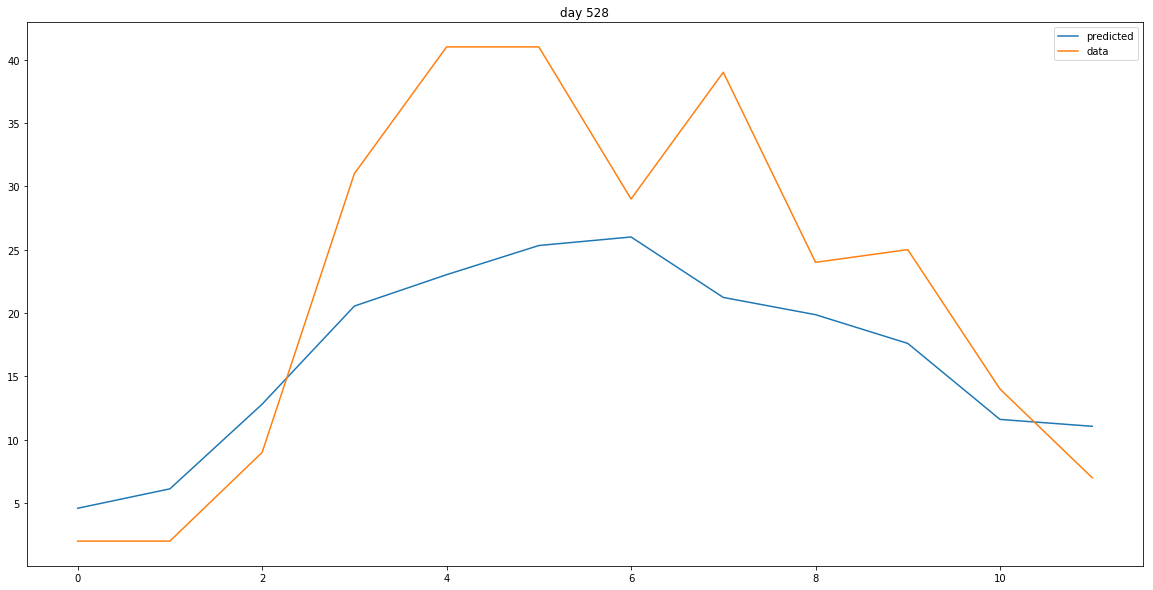

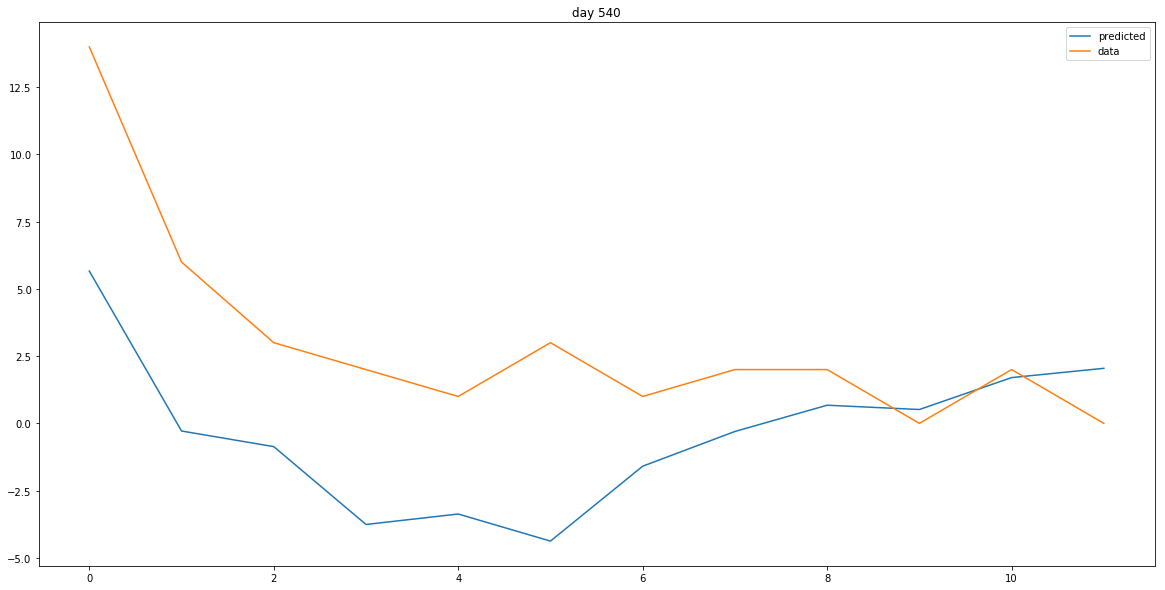

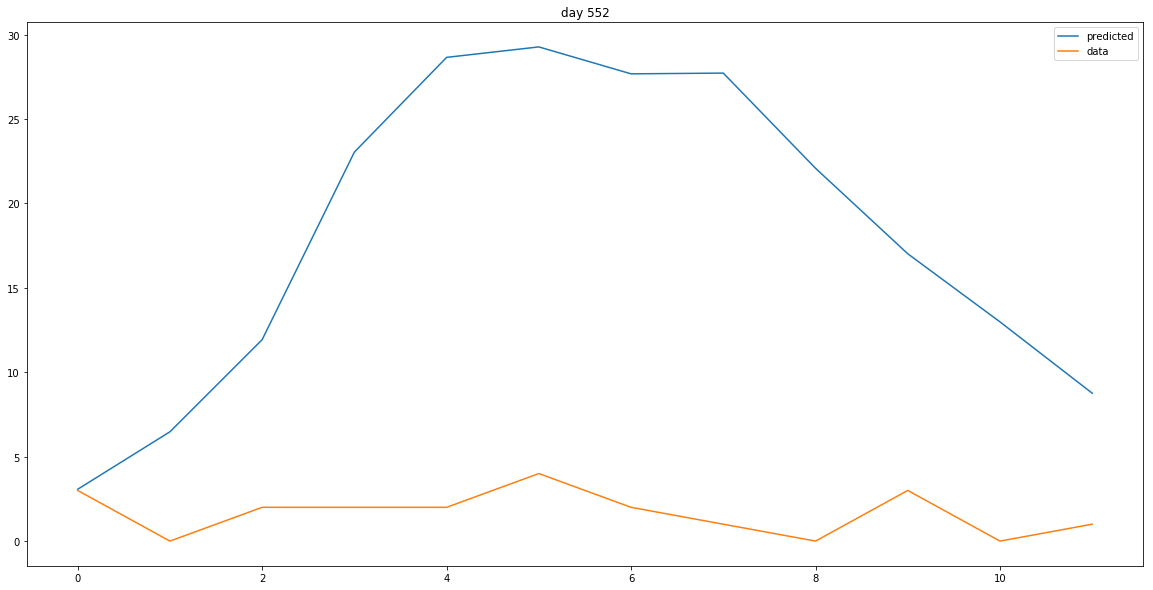

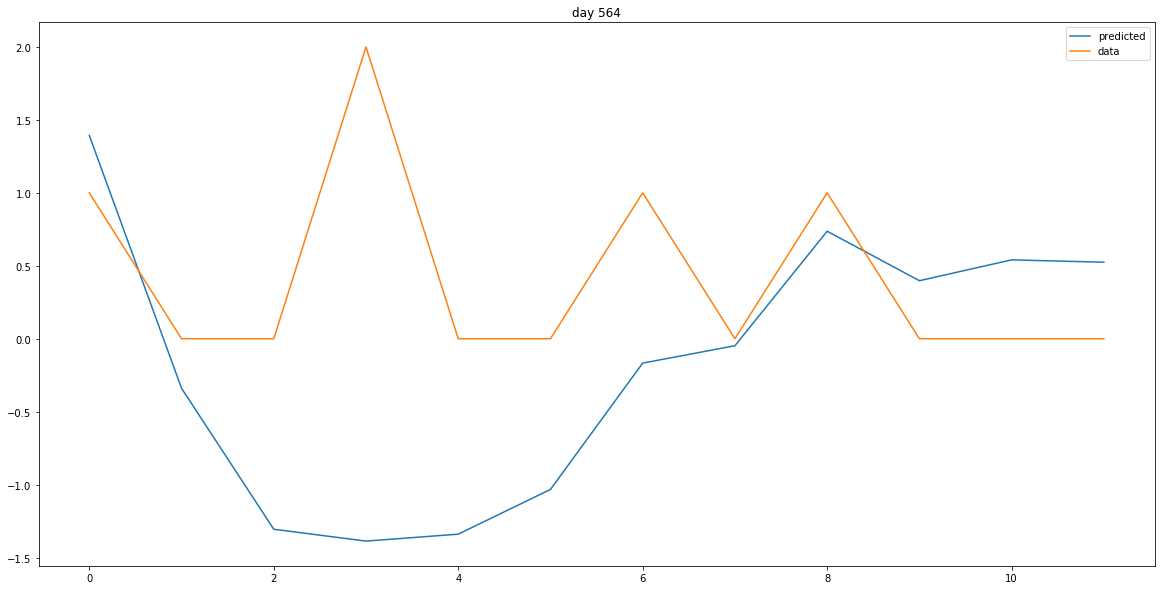

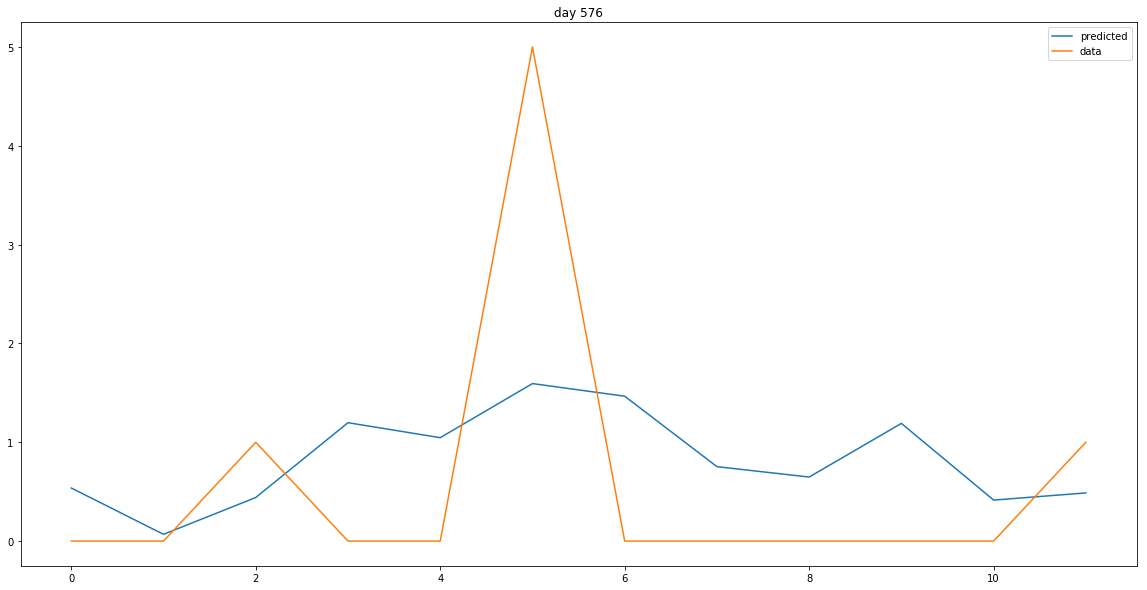

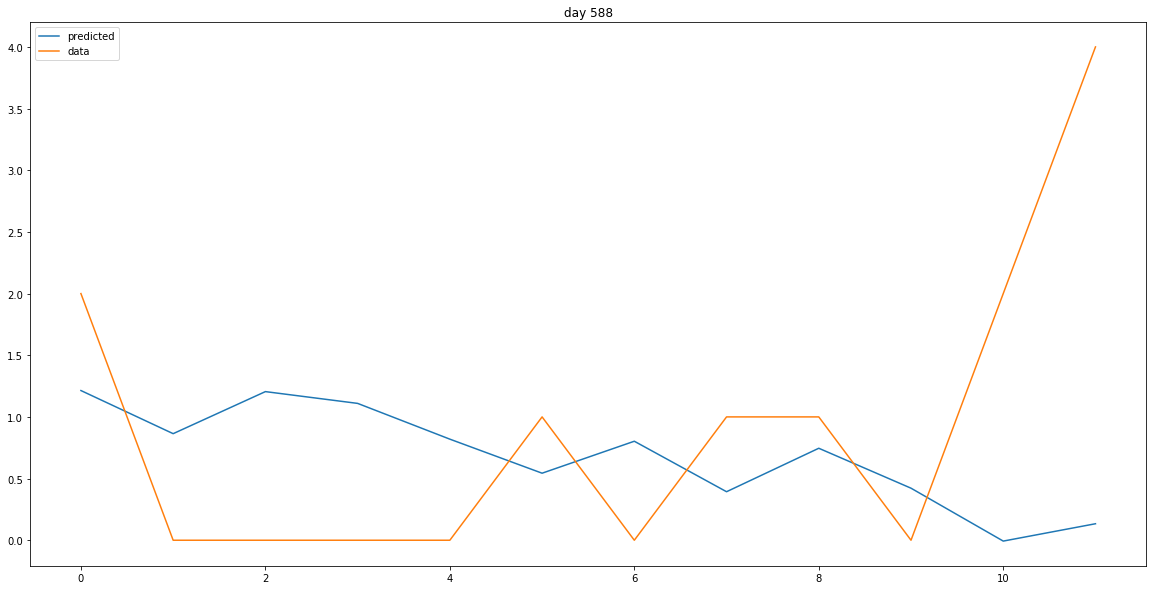

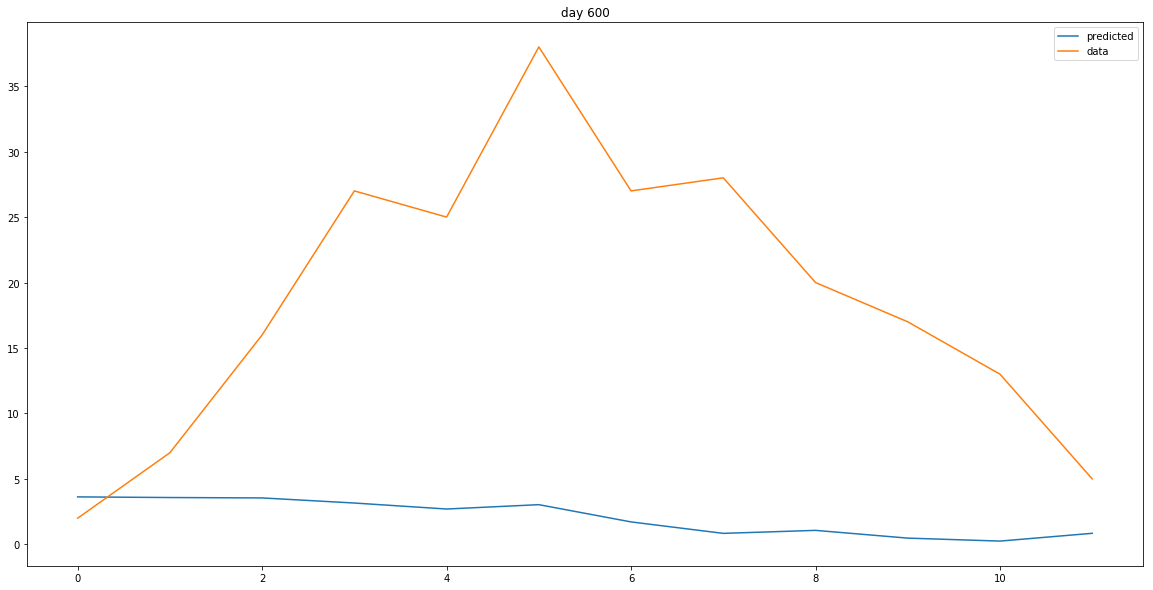

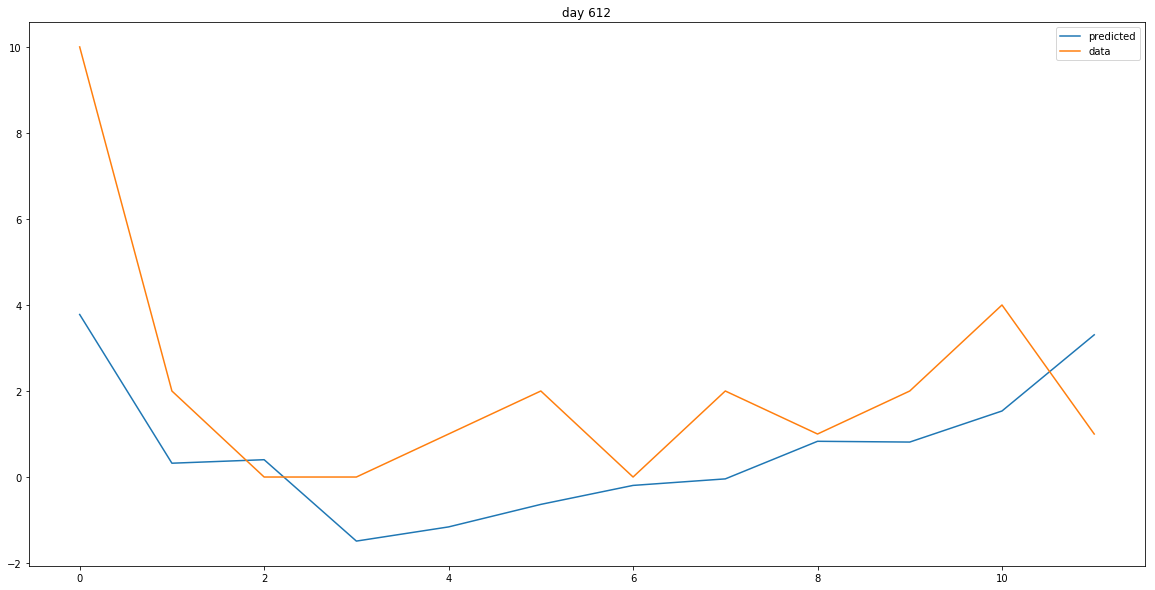

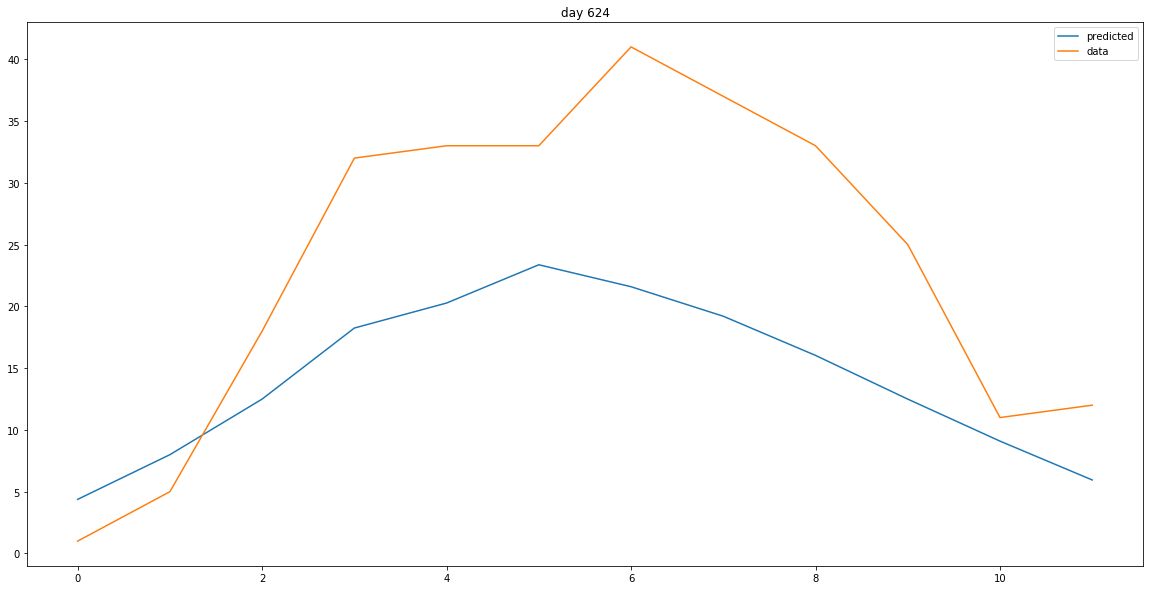

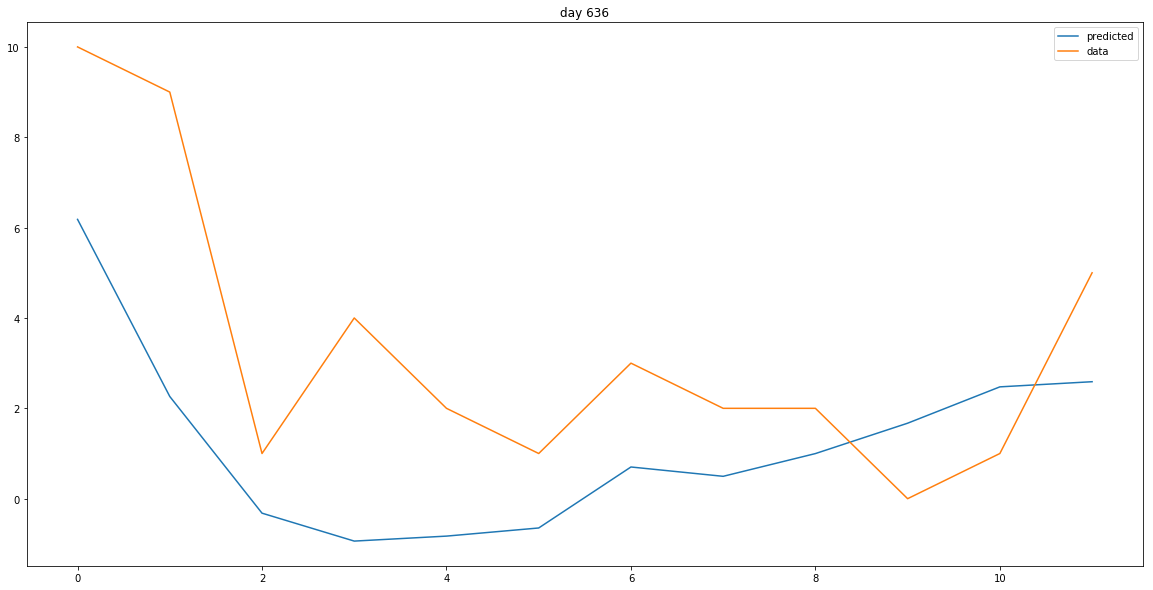

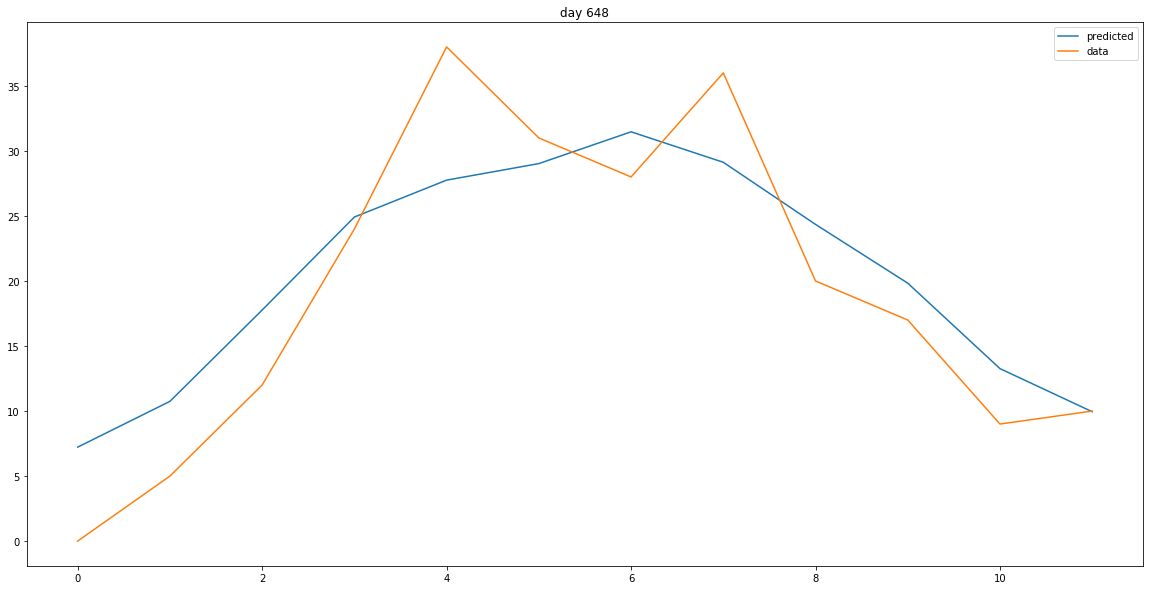

0.23089291014656096


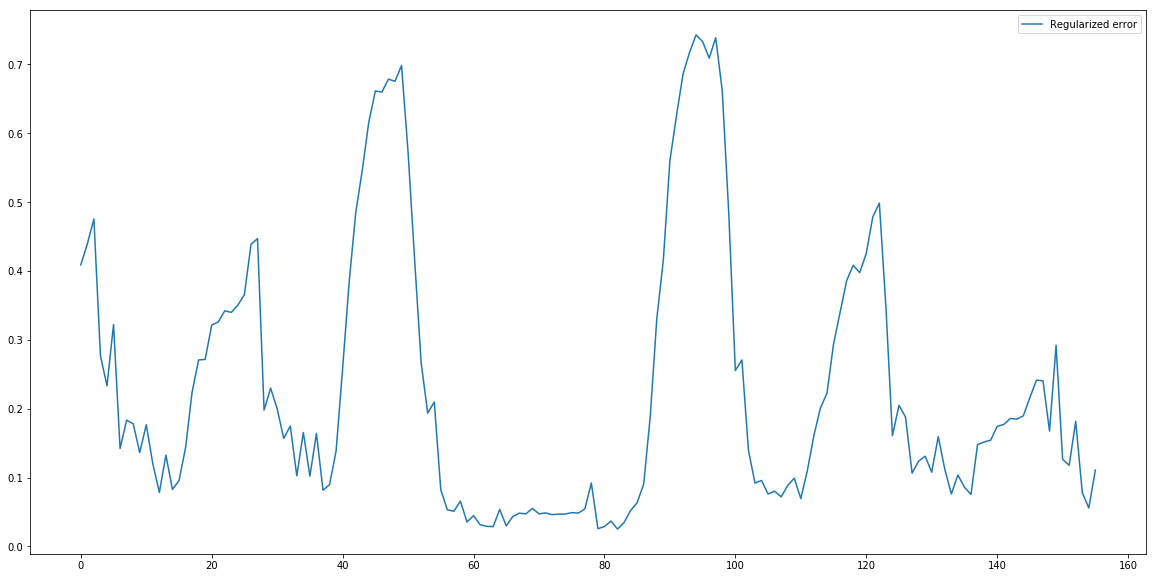

In [16]:
err = []

for i in range(num_train,num_test) :
    train = y[:i]
    test = y[i:]
    Ntest = len(test)
    Ntrain = len(train)
    model = AR(train)
    model_fit = model.fit(Ntrain -24)
    yhat = np.array(model_fit.predict(Ntrain,len(y)-1)[:12])
    err.append(compute_err(yhat,np.array(test[:12]),mu))
    if i%12 == 0 :
        plt.figure(figsize = (20,10))
        plt.plot(range(len(yhat[:12])),yhat[:12],label = 'predicted')
        plt.plot(range(len(yhat[:12])),test[:12], label = 'data')
        plt.title('day ' + str(i))
        plt.legend()
        plt.show()
    
print(np.sum(err)/len(err))
plt.figure(figsize = (20,10))
plt.plot(range(len(err)),err,label = 'Regularized error')
plt.legend()

I did 90 24-hours predictions and computed the error the mean error is 0.17 wich correspond to a mean error of 0.5 trucks pert time step. The average number of trucks is 3.2.

0


D:\program\Anaconda\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
D:\program\Anaconda\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
D:\program\Anaconda\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[n

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
0.3138775751912495
0.3138775751912495 10 0 0


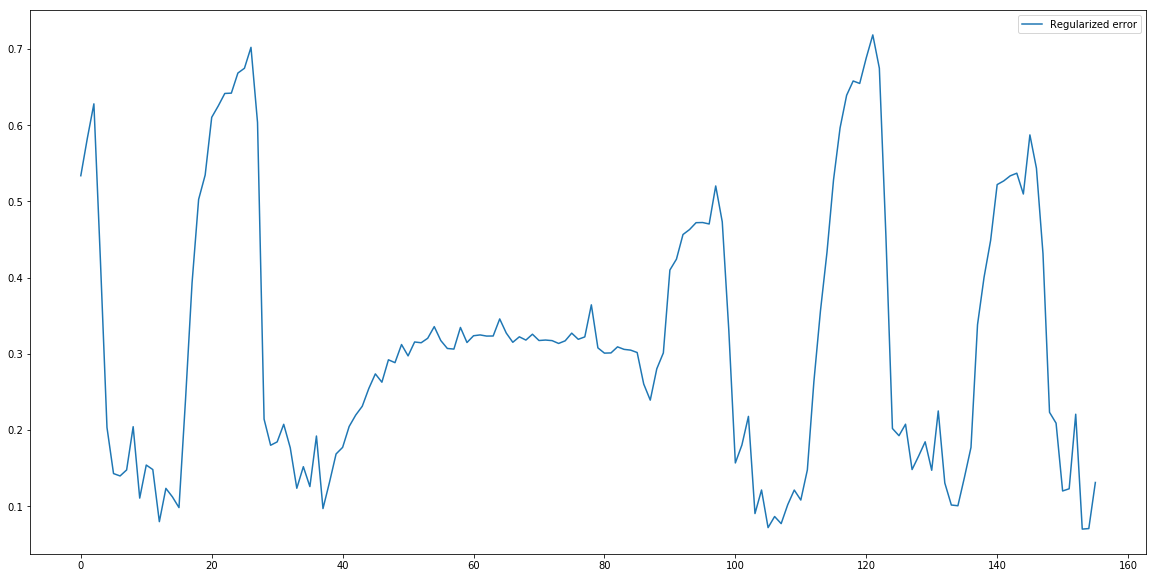

In [17]:
def mean(err) :
    N = len(err)
    return(np.sum(np.array(err))/N)
err = []
p,q,r = 10,0,0

for i in range(num_train,num_test) :
    k = i - num_train
    print(k)
    train = y[:i]
    test = y[i:]
    Ntest = len(test)
    Ntrain = len(train)
    model = ARIMA(train,order=(p,q,r))
    model_fit = model.fit()
    yhat = model_fit.predict(len(train),len(y)-1)
    err.append(compute_err(yhat[:12],test[:12],mu))



print(np.sum(err)/len(err))
plt.figure(figsize = (20,10))
plt.plot(range(len(err)),err,label = 'Regularized error')
plt.legend()
    
print(mean(err),p,q,r)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
0.3039873456248162
0.3039873456248162 20 0 0


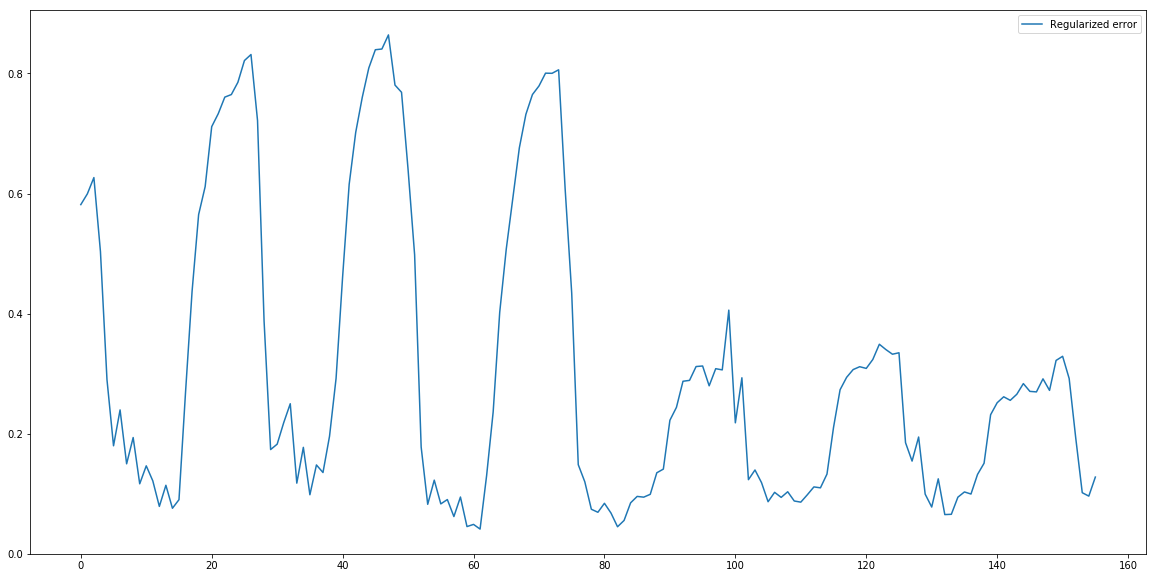

In [19]:
err = []
p = 20
for i in range(num_train,num_test) :
    k = i - num_train
    print(k)
    train = y_noseason[:i]
    test = y_noseason[i:]
    Ntest = len(test)
    Ntrain = len(train)
    model = ARIMA(train,order=(p,q,r))
    model_fit = model.fit(disp=  0)
    yhat = model_fit.predict(len(train),len(y)-1)
    err.append(compute_err(yhat[:12],test[:12],mu))



print(np.sum(err)/len(err))
plt.figure(figsize = (20,10))
plt.plot(range(len(err)),err,label = 'Regularized error')
plt.legend()
    
print(mean(err),p,q,r)

In [20]:
A = [y[i]-y[i-1] for i in range(1,len(y))]
train = A[:600]
test = A[600:]
Ntest = len(test)
Ntrain = len(train)
model = ARIMA(train,order=(5,1,0))
model_fit = model.fit(disp=  0)
yhat = model_fit.predict(len(train),len(A)-1)

D:\program\Anaconda\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
D:\program\Anaconda\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
D:\program\Anaconda\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[n

Naive Methods.